#**Bayesian Optimisation**
Bayesian Optimization is a probabilistic technique  uses Bayes Theorem  in order to find the minimum or maximum of an objective function.

Bayes Theorem: $P(x|y) =\displaystyle \frac{P(y|x) * P(x)}{P(y)}$

Given a sample $(x_1, x_2, …, x_n)$, we can evaluate them using the objective function $f(x_i)$ . Samples and their outcome are collected which  define our data D, e.g. D = $\{x_i, f(x_i)\}_{n=1}^N$ which can be used as the prior. The likelihood  is defined as the probability of observing the data given the function $P(D | f)$. Then the posterior could be defined as $P(f|D) = P(D|f) * P(f)$ which  captures the updated beliefs about the unknown objective function.

Let $y = x^2sin(3\pi x)^4$ where $x \in[0,1]$ and augment this function by adding Gaussian noise $\epsilon \sim N(0|{(0.1)}^2)$.

Global Optima at (x=0.840,y=0.700)


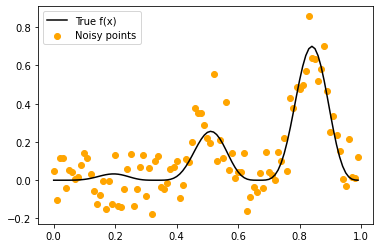

In [ ]:
import math
import numpy as np
import matplotlib.pyplot as plt

def Truefunc(x, noise=0.1):
	noise = np.random.normal(loc=0, scale=noise)
	return (x**2 * math.sin(3 * math.pi * x)**4) + noise

X = np.arange(0, 1, 0.01)
y = [Truefunc(x, 0) for x in X]
ynoise = [Truefunc(x) for x in X]
index = np.argmax(y)
print('Global Optima at (x=%.3f,y=%.3f)' % (X[index], y[index]))
plt.scatter(X, ynoise,color='orange',label='Noisy points')
plt.plot(X, y,color='black',label='True f(x)')
plt.legend()
plt.show()

**Surrogate function:**

The surrogate function is used to get an estimate of the objective function, which can be used for future sampling. Probabilistically, it summarizes the conditional probability of an objective function $f$, given the data $D$ i.e $P(f|D)$. We can treat the problem as a regression predictive modeling problem with the data representing the input and the score representing the output. This is often best modeled by a Gaussian Process(GP).


/usr/local/lib/python3.7/dist-packages/sklearn/gaussian_process/_gpr.py:362: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "


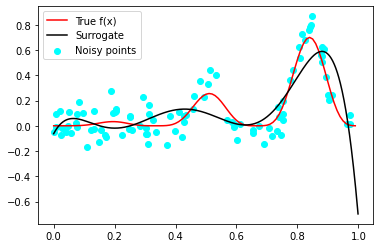

In [ ]:
from sklearn.gaussian_process import GaussianProcessRegressor
 
plt.plot(X, y,color='red',label='True f(x)')
def sfunc(model, X):
	return model.predict(X, return_std=True)
 
X = np.random.random(100)
y = np.asarray([Truefunc(x) for x in X])
X = X.reshape(len(X), 1)
y = y.reshape(len(y), 1)
model = GaussianProcessRegressor()
model.fit(X, y)
plt.scatter(X, y,color='cyan',label='Noisy points')
Xsamples = np.asarray(np.arange(0, 1, 0.001))
Xsamples = Xsamples.reshape(len(Xsamples), 1)
ysamples, _ = sfunc(model, Xsamples)
plt.plot(Xsamples, ysamples,color='black',label='Surrogate')
plt.legend()
plt.show()



The plot resembles a crude version of the underlying non-noisy objective function, with a peak around the around the same coordinate where we know the true maxima is located.

**Acquisition Function:** 

Technique by which the posterior is used to select the next sample from the search space. The surrogate function is used to test a range of candidate samples. From which one or more candidates can be selected and evaluated. The search strategy used to navigate the domain in response to the surrogate function and the acquisition function that is used to interpret and score the response from the surrogate function. Here I will use a random search or random sample of the domain. This involves first drawing a random sample of candidate samples from the domain, evaluating them with the acquisition function, then maximizing the acquisition function.

In [ ]:

from scipy.stats import norm
from warnings import catch_warnings
from warnings import simplefilter

X = np.random.random(100)
y = np.asarray([Truefunc(x) for x in X])
X = X.reshape(len(X), 1)
y = y.reshape(len(y), 1)
model = GaussianProcessRegressor()
model.fit(X, y)

def sfunc(model, X):
	with catch_warnings():
		simplefilter("ignore")
		return model.predict(X, return_std=True)

for i in range(100):
    Xsamples = np.random.random(100)
    Xsamples = Xsamples.reshape(len(Xsamples), 1)
    yhat, _ = sfunc(model, X)
    best = max(yhat)
    mu, std = sfunc(model, Xsamples)
    mu = mu[:, 0]
    probs = norm.cdf((mu - best) / (std+1E-9))
    scores = probs
    ix = np.argmax(scores)
    x=Xsamples[ix, 0]
    actual = Truefunc(x)
    est, _ = sfunc(model, [[x]])
    X = np.vstack((X, [[x]]))
    y = np.vstack((y, [[actual]]))
    model.fit(X, y)
    print('x=%.3f, estimated value=%.3f, actual value=%.3f' % (x, est, actual))


x=0.877, estimated value=0.470, actual value=0.622
x=0.875, estimated value=0.479, actual value=0.546
x=0.035, estimated value=-0.023, actual value=0.130
x=0.873, estimated value=0.482, actual value=0.789
x=0.882, estimated value=0.496, actual value=0.687
x=0.879, estimated value=0.508, actual value=0.533
x=0.876, estimated value=0.509, actual value=0.637
x=0.033, estimated value=0.004, actual value=0.038
x=0.845, estimated value=0.483, actual value=0.696
x=0.849, estimated value=0.500, actual value=0.587
x=0.842, estimated value=0.490, actual value=0.646
x=0.205, estimated value=-0.086, actual value=0.256
x=0.877, estimated value=0.531, actual value=0.621
x=0.880, estimated value=0.533, actual value=0.435
x=0.858, estimated value=0.521, actual value=0.622
x=0.842, estimated value=0.499, actual value=0.684
x=0.870, estimated value=0.540, actual value=0.626
x=0.869, estimated value=0.542, actual value=0.598
x=0.873, estimated value=0.545, actual value=0.533
x=0.873, estimated value=0.54

The algorithm then iterates for 100 cycles, selecting samples, evaluating them, and adding them to the dataset to update the surrogate function. Each cycle reports the selected input value, the estimated score from the surrogate function, and the actual score. 

This time, all 200 samples evaluated during the optimization task are plotted. We would expect an overabundance of sampling around the known optima, and this is what we see, with may dots around 0.840.

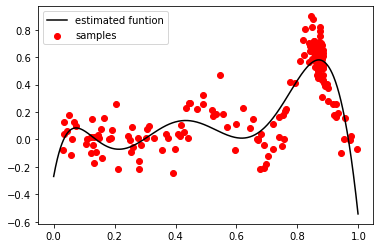

Predicted Optima: x=0.845, y=0.899


In [ ]:

plt.scatter(X, y,color='red',label='samples')
Xsamples = np.asarray(np.arange(0, 1, 0.001))
Xsamples = Xsamples.reshape(len(Xsamples), 1)
ysamples, _ = sfunc(model, Xsamples)
plt.plot(Xsamples, ysamples,color='black',label='estimated funtion')
plt.legend()
plt.show()
ix = np.argmax(y)
print('Predicted Optima: x=%.3f, y=%.3f' % (X[ix], y[ix]))


We know the optima is at x=0.840, if there was no sampling noise. Given the sampling noise, the Bayesian optimization algorithm gets close in this case, suggesting optima at x=0.845.

#**Summary**
Bayesian optimization is a sequential design strategy for global optimization of black-box functions that does not assume any functional forms. It is usually employed to optimize expensive-to-evaluate functions.

The  Bayesian Optimization algorithm can be given as

Repeat following steps until converged:

* Step 1: Select a Sample by Optimizing the Acquisition Function.
* Step 2: Evaluate the Sample With the Objective Function.
* Step 3: Update the Data and the Surrogate Function.
 